In [1]:
#SIZE_TEST = 50000
N_SENTENCES_TRAIN = 2500 # 25000
N_SENTENCES_TEST = 1000 # 1000
N_EPOCHS = 2
CACHED = True

In [2]:
import sys
sys.path.append('../src')

In [3]:
import numpy as np

In [4]:
%load_ext rpy2.ipython

# Creates Dataset

In [5]:
# Creates Arithmetic dataset
import dataset
reload(dataset)

data_obj = dataset.Arithmetic()
data_obj.create(n_sentences_train=N_SENTENCES_TRAIN, n_sentences_test=N_SENTENCES_TEST, cfactor=.25)

Using TensorFlow backend.


Generating raw text, with training size: 2500 and testing size 1000
Generated train sequence - 111676 characters
Generated test sequence - 43670 characters
Total vocabulary size:  17
Total Patterns:  111641
Total Patterns:  43635


In [6]:
print data_obj.train['X'].shape
print data_obj.train['y'].shape
print len(data_obj.train_raw)
print ''
print data_obj.test['X'].shape
print data_obj.test['y'].shape
print len(data_obj.test_raw)
print data_obj.test_raw[:50]

(111641, 35, 17)
(111641, 17)
111676

(43635, 35, 17)
(43635, 17)
43670
['(', '0', '*', '(', '1', ')', '-', '(', '0', '*', '8', ')', '/', '5', ')', ',', '5', ',', '9', ',', '(', '8', '+', '6', '/', '5', '*', '(', '1', ')', '-', '3', '/', '8', '*', '2', '-', '2', ')', ',', '2', ',', '6', '+', '0', '+', '8', '-', '(', '7']


# Creates and trains character model

In [7]:
import model
reload(model)

nn_model = model.VanillaLSTM(data_obj, 128, n_epochs=1)
nn_model.build()

if CACHED:
    nn_model.load_from_file('../models/arithmetic_1')
else:
    for i in range(N_EPOCHS):
        nn_model.train()
        nn_model.save('../models/arithmetic_' + str(i))

In [8]:
# Creates a sentence

nn_model.complete_sentence(50)

Dimensions: (1, 35, 17)
[12  3  0 11  2 14  1  6 11  6  0  0 13  5  9  1  3  8  5  0 15  5 11  2 16
  6  7  1  1  2  0  0 12  1  2 16  3 11  5 16  3 13  2 15  5 15  2 13  6  8
  1  4  9  6  0  7  5 16  3  0 16  1  5  8  5 11  3 11  2 14  3 12  1  2  0
  0 15  1  5  9  5 13  6  7  3]


'5+(4*7)/4/((6-2)+1-(8-4*9/0))*((5)*9+4-9+6*8-8*6/1),2/(0-9+(9)-1-4+4*7+5)*((8)-2-6/0+'

# Extracts States

In [9]:
# Gets hidden states
states = nn_model.extract_states()
print states.shape

(43670, 32)


# Creates Features

In [10]:
import features
reload(features)

features_obj = features.GrammarFeature(data_obj)
features_obj.build_feature_functions()
computed_features = features_obj.compute_feat_matrix()

print computed_features['feat_matrix'].shape
print len(computed_features['labels'])

Parsed 0 symbols out of 43670
Stack size: 0
Parsed 1000 symbols out of 43670
Stack size: 5
Parsed 2000 symbols out of 43670
Stack size: 5
Parsed 3000 symbols out of 43670
Stack size: 3
Parsed 4000 symbols out of 43670
Stack size: 3
Parsed 5000 symbols out of 43670
Stack size: 5
Parsed 6000 symbols out of 43670
Stack size: 5
Parsed 7000 symbols out of 43670
Stack size: 3
Parsed 8000 symbols out of 43670
Stack size: 9
Parsed 9000 symbols out of 43670
Stack size: 9
Parsed 10000 symbols out of 43670
Stack size: 1
Parsed 11000 symbols out of 43670
Stack size: 3
Parsed 12000 symbols out of 43670
Stack size: 5
Parsed 13000 symbols out of 43670
Stack size: 3
Parsed 14000 symbols out of 43670
Stack size: 3
Parsed 15000 symbols out of 43670
Stack size: 5
Parsed 16000 symbols out of 43670
Stack size: 3
Parsed 17000 symbols out of 43670
Stack size: 5
Parsed 18000 symbols out of 43670
Stack size: 3
Parsed 19000 symbols out of 43670
Stack size: 9
Parsed 20000 symbols out of 43670
Stack size: 3
Parse

# Computes scores

In [11]:
import score

score_obj = score.MultiNeuronPred(states, 
                computed_features['feat_matrix'],
                computed_features['labels'])
score_obj.compute_scores()

print score_obj.neuron_scores.shape
print score_obj.model_scores

Scoring feature 0 out of 34
Feature: trig_SENTENCE
Fitting model
Cant compute score
Feature: trig_EXPR
Fitting model
Cant compute score
Feature: 

/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


trig_MIN
Fitting model
Computing score
Accuracy: 0.813413246838
Feature: trig_N
Fitting model
Computing score
Accuracy: 0.607643428633
Feature: trig_ADD
Fitting model
Computing score
Accuracy: 0.812734542545
Feature: trig_PAREN
Fitting model
Computing score
Accuracy: 0.768417799111
Feature: trig_MUL
Fitting model
Computing score
Accuracy: 0.812666051247
Feature: trig_DIV
Fitting model
Computing score
Accuracy: 0.812344178397
Feature: trig_DATASET
Fitting model
Computing score
Accuracy: 0.734257589553
Feature: depth_SENTENCE_1
Fitting model
Cant compute score
Scoring feature 10 out of 34
Feature: depth_SENTENCE_*
Fitting model
Cant compute score
Feature: depth_EXPR_1
Fitting model
Computing score
Accuracy: 0.0743432495784
Feature: depth_EXPR_2
Fitting model
Computing score
Accuracy: 0.108396616694
Feature: depth_EXPR_*
Fitting model
Computing score
Accuracy: 0.999847594931
Feature: depth_MIN_1
Fitting model
Computing score
Accuracy: 0.359714211009
Feature: depth_MIN_2
Fitting model
Comp

Feature scores: 34
Features: 34


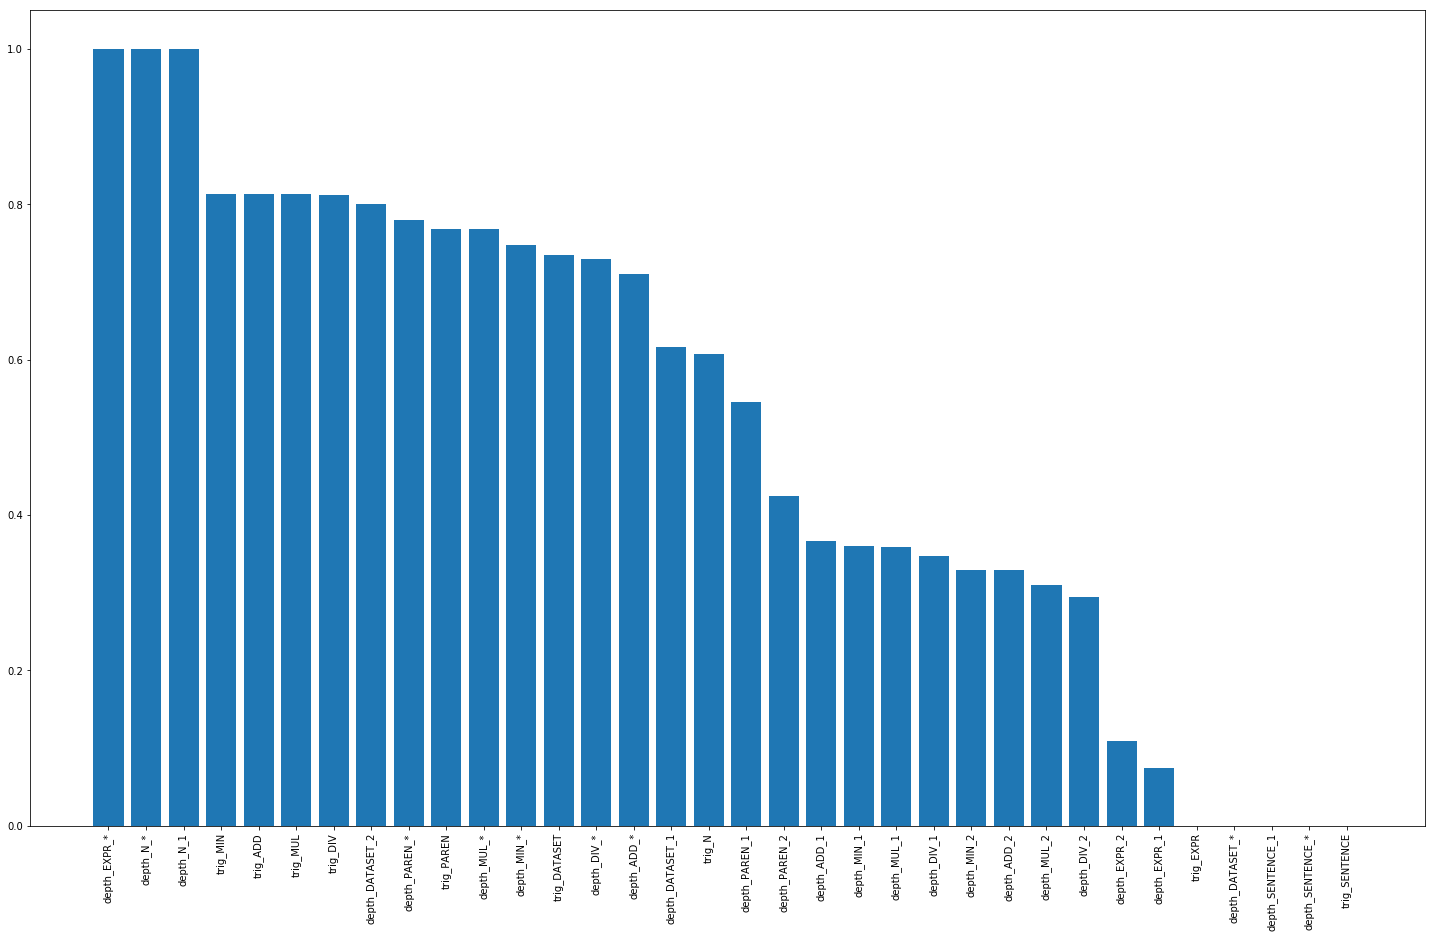

In [17]:
# First viz: shows score per rule

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import numpy as np
%matplotlib inline


fig_size = [25,15]
plt.rcParams["figure.figsize"] = fig_size

feat_scores = score_obj.model_scores
feat_names =  computed_features['labels']
print 'Feature scores:', len(feat_scores)
print 'Features:', len(feat_names)

dorder = np.argsort(feat_scores)[::-1][:50]

scores = np.array(feat_scores)[dorder]
names = np.array(feat_names)[dorder]

fig, ax = plt.subplots()
plt.bar(np.arange(dorder.shape[0]), scores)
plt.xticks(np.arange(dorder.shape[0]), names, rotation='vertical')

plt.show()
# print feat_names[order]

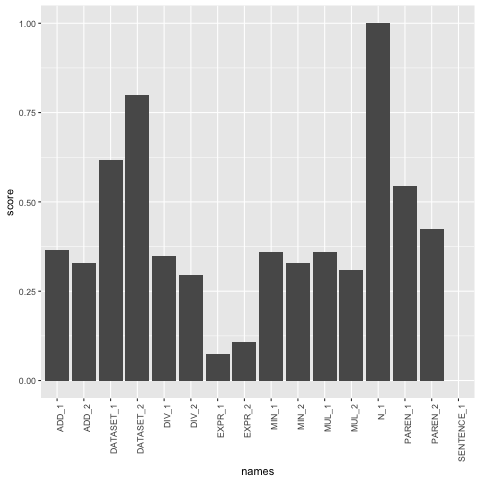

In [50]:
%%R -i feat_scores,feat_names
library(dplyr)
library(ggplot2)

df <- data.frame(names = as.character(feat_names), score = feat_scores)
df <- df %>% filter(grepl("depth", feat_names)) %>% mutate(names = sub('depth_', '', names))

# Plot 1
df1 <- df %>% filter(grepl("_\\*$", names)) %>%  mutate(names = sub('_\\*', '', names))
ggplot(df1, aes(x=names, y=score)) + geom_bar(stat='identity')

# Plot 2
df1 <- df %>% filter(!grepl("_\\*$", names)) %>%  mutate(names = sub('_*', '', names))

ggplot(df1, aes(x=names, y=score)) + geom_bar(stat='identity') +theme(axis.text.x = element_text(angle = 90, hjust = 1))

Filtering feature matrix


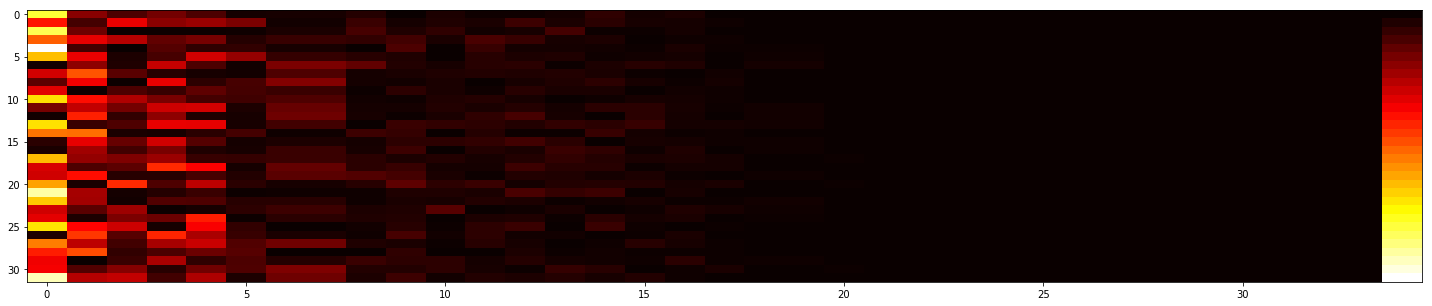

0 trig_SENTENCE
1 trig_EXPR
2 trig_MIN
3 trig_N
4 trig_ADD
5 trig_PAREN
6 trig_MUL
7 trig_DIV
8 trig_DATASET
9 depth_SENTENCE_1
10 depth_SENTENCE_*
11 depth_EXPR_1
12 depth_EXPR_2
13 depth_EXPR_*
14 depth_MIN_1
15 depth_MIN_2
16 depth_MIN_*
17 depth_N_1
18 depth_N_*
19 depth_ADD_1
20 depth_ADD_2
21 depth_ADD_*
22 depth_PAREN_1
23 depth_PAREN_2
24 depth_PAREN_*
25 depth_MUL_1
26 depth_MUL_2
27 depth_MUL_*
28 depth_DIV_1
29 depth_DIV_2
30 depth_DIV_*
31 depth_DATASET_1
32 depth_DATASET_2
33 depth_DATASET_*


In [12]:
# Second viz: shows neurons activated for each rule

N_FEATURES_TO_PLOT = 35

to_plot = score_obj.filter_scores(N_FEATURES_TO_PLOT)

n_values   = to_plot.shape[0]
dummy_vals = np.linspace(0,np.max(to_plot),num=n_values)
dummy_vals = np.expand_dims(dummy_vals, axis=1)
to_plot  = np.append(to_plot, dummy_vals, axis = 1)

plt.imshow(to_plot, cmap='hot',
                      norm=Normalize(vmin=0),
                      interpolation='nearest',
                      aspect='auto')
plt.show()
#plt.savefig('correlation_matrix.pdf',  bbox_inches='tight')

for i,l in enumerate(computed_features['labels'][:N_FEATURES_TO_PLOT]):
    print i,l

In [13]:
print len(computed_features['labels'])
print computed_features['feat_matrix'].shape

34
(43496, 34)


# Computes Neuron-specific scores

In [51]:
reload(score)
score_obj = score.CorrelationScore(states, computed_features['feat_matrix'], 
                computed_features['labels'])
score_obj.compute_scores()

#print score_obj.neuron_scores
#print score_obj.model_scores
#print score_obj.feature_names

print len(score_obj.model_scores)
print score_obj.neuron_scores.shape
print len(score_obj.feature_names)

Scoring feature 0 out of 34


/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/numpy/lib/function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Scoring feature 10 out of 34
Scoring feature 20 out of 34
Scoring feature 30 out of 34
Scoring feature 33 out of 34
32
(32, 34)
34


(32, 34)
34


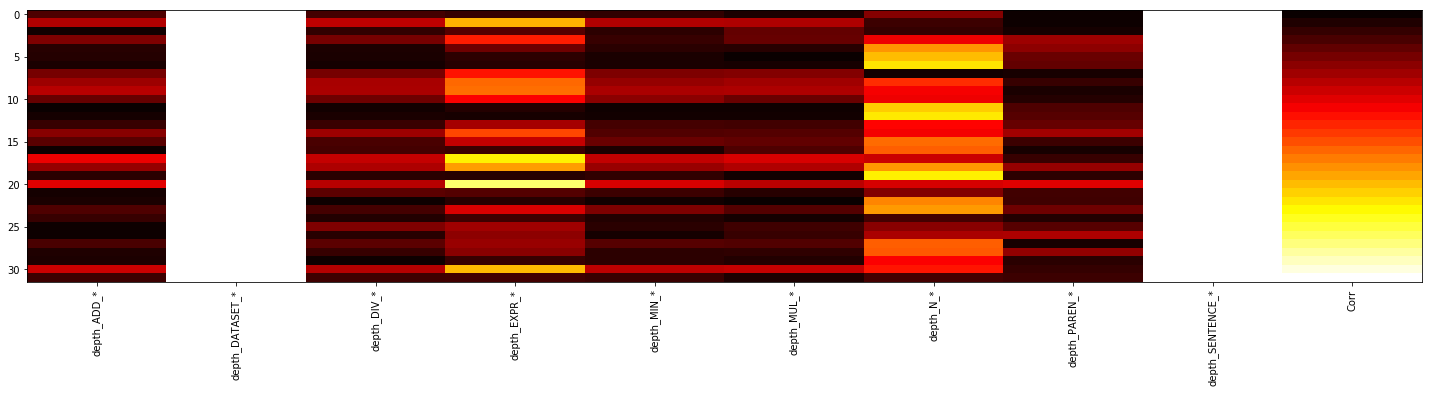

NameError: name 'N_FEATURES_TO_PLOT' is not defined

In [54]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import numpy as np

# Setup of figure
fig_size = [25,5]
plt.rcParams["figure.figsize"] = fig_size

# Gets data to plot
to_plot = score_obj.neuron_scores
print to_plot.shape
feat_names = score_obj.feature_names[:]
print len(feat_names)

# Sorts by alphabetical order
idx = sorted(range(len(feat_names)), key=lambda x:feat_names[x])
to_plot = to_plot[:,idx]
feat_names = [feat_names[i] for i in idx]

# IF NECESSARY FILTERS:
idx = [i for i,f in enumerate(feat_names) if '*' in f]
to_plot = to_plot[:,idx]
feat_names = [feat_names[i] for i in idx]

# Adds dummy column for legend
n_values   = to_plot.shape[0]
dummy_vals = np.linspace(0,1,num=n_values)
dummy_vals = np.expand_dims(dummy_vals, axis=1)
to_plot  = np.append(to_plot, dummy_vals, axis = 1)
feat_names.append('Corr')

fig, ax = plt.subplots()
plt.imshow(to_plot, cmap='hot',
                      norm=Normalize(vmin=0),
                      interpolation='nearest',
                      aspect='auto')
plt.xticks(np.arange(len(feat_names)), feat_names, rotation='vertical')
plt.show()
#plt.savefig('correlation_matrix.pdf',  bbox_inches='tight')

print computed_features['labels'][:N_FEATURES_TO_PLOT]

In [60]:
# Gets data to plot
to_plot = score_obj.neuron_scores
print to_plot.shape
feat_names = score_obj.feature_names[:]
print len(feat_names)

(32, 34)
34


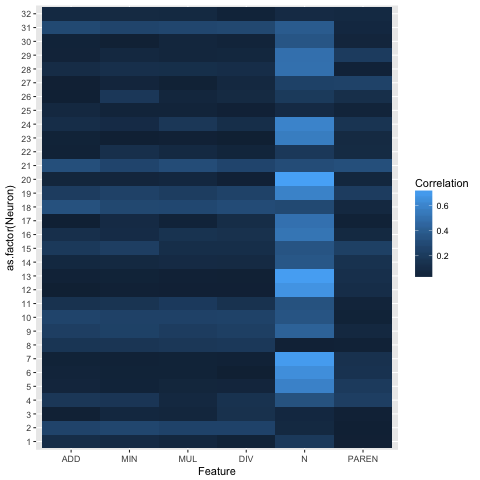

In [70]:
%%R -i to_plot,feat_names
library(tidyr)
data <- as.data.frame(to_plot)
names(data) <- feat_names

data[['Neuron']] <- 1:nrow(data)
data <- gather(data, key='Feature', value='Correlation', -Neuron)

df1 <- data %>% filter(grepl("_\\*$", Feature)) %>%  mutate(Feature = sub('_\\*', '', Feature))
df1 <- df1 %>% filter(grepl("depth", Feature)) %>% mutate(Feature = sub('depth_', '', Feature))

df1 <- df1 %>% filter(Feature %in% c('ADD','MIN','MUL','DIV', 'N', 'PAREN'))

ggplot(df1, aes(x=Feature, y=as.factor(Neuron), fill=Correlation)) +
        geom_bin2d(aes='identity') +
        scale_x_discrete(labels=c('ADD','MIN','MUL','DIV', 'N', 'PAREN'))

(32, 34)
34
depth_SENTENCE_*
depth_EXPR_*
depth_MIN_*
depth_N_*
depth_ADD_*
depth_PAREN_*
depth_MUL_*
depth_DIV_*
depth_DATASET_*


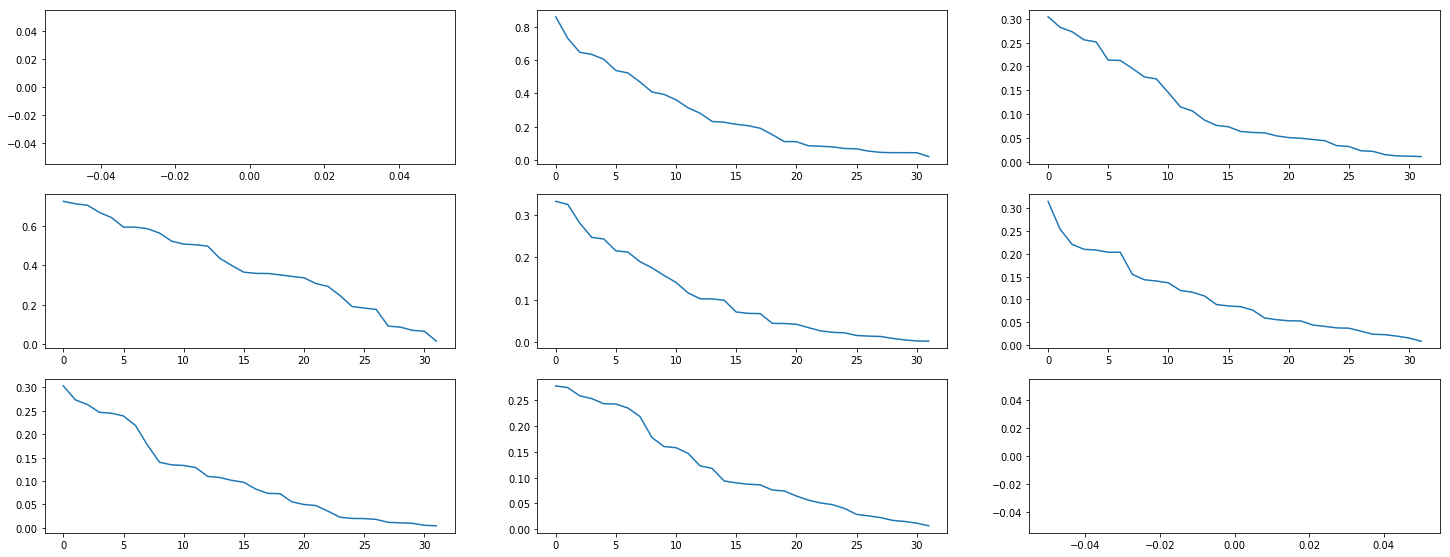

In [16]:
# Second viz
# Setup of figure
fig_size = [25,30]
plt.rcParams["figure.figsize"] = fig_size

# Gets data to plot
to_plot = score_obj.neuron_scores
print to_plot.shape
feat_names = score_obj.feature_names[:]
print len(feat_names)

# Sorts by alphabetical order
idx = sorted(range(len(feat_names)), key=lambda x:feat_names[i])
to_plot = to_plot[:,idx]
feat_names = [feat_names[i] for i in idx]

# IF NECESSARY FILTERS:
idx = [i for i,f in enumerate(feat_names) if '*' in f]
to_plot = to_plot[:,idx]
feat_names = [feat_names[i] for i in idx]


if to_plot.shape[1] <= 4:
    ncol = 1
elif 4 < to_plot.shape[1] <= 8:
    ncol = 2
else:
    nplots = min(12, to_plot.shape[1])
    to_plot = to_plot[:,:nplots]
    ncol = 3

for i in range(to_plot.shape[1]):
    print feat_names[i]
    neuron_series = np.sort(to_plot[:,i])[::-1]
    plt.subplot(to_plot.shape[1],ncol,i+1)
    plt.plot(neuron_series)

plt.show()

# Adds nonsense rules to get counter-examples